In [1]:
import os
if "RANK_TABLE_FILE" in os.environ:
    del os.environ["RANK_TABLE_FILE"]
import numpy as np
import matplotlib.pyplot as plt
import mindspore as ms
from mindspore import nn, ops, Tensor, Parameter
from mindspore.common.initializer import XavierUniform
import mlp_ms
import snalu_ms

SEED = 123
np.random.seed(SEED)
ms.set_seed(SEED)
def create_data(min_val, max_val, n_elts, fun_op, fun_name, single_dim=False):
    if single_dim:
        if fun_name == 'sqrt':
            min_val = max(min_val, 0)
        x = np.random.randint(low=min_val, high=max_val + 1, size=(n_elts, 1))
        y = fun_op(x).reshape(-1)
    else:
        x = np.random.randint(low=min_val, high=max_val + 1, size=(n_elts, 2))
        if fun_name == 'div':
            x = x[np.nonzero(x[:, 1])]
        y = fun_op(x[:, 0], x[:, 1])
    x = Tensor(x, dtype=ms.float32)
    y = Tensor(y, dtype=ms.float32)
    return x, y



In [ ]:
import mindspore as ms
import mindspore.ops as ops
from mindspore import Tensor

def split_data(data, less, greater, test_percentage=0.2):
    x, y = data

    reduce_all = ops.ReduceAll(keep_dims=False)
    reduce_any = ops.ReduceAny(keep_dims=False)
    nonzero = ops.NonZero()
    reshape = ops.Reshape()
    logical_and = ops.LogicalAnd()
    logical_or = ops.LogicalOr()
    greater_equal = ops.GreaterEqual()
    less_equal = ops.LessEqual()
    less_op = ops.Less()
    greater_op = ops.Greater()
    

    mask_inter = reduce_all(
        logical_and(
            greater_equal(x, less),
            less_equal(x, greater)
        ),
        axis=1
    )
    mask_extra_less = reduce_any(less_op(x, less), axis=1)
    mask_extra_greater = reduce_any(greater_op(x, greater), axis=1)
    mask_extra = logical_or(mask_extra_less, mask_extra_greater)


    indices_inter = reshape(nonzero(mask_inter), (-1,))
    indices_extra = reshape(nonzero(mask_extra), (-1,))


    x_inter = x[indices_inter]
    y_inter = y[indices_inter]
    x_extra = x[indices_extra]
    y_extra = y[indices_extra]


    perm = np.random.permutation(x_inter.shape[0])
    x_inter = x_inter[perm.tolist()] 
    y_inter = y_inter[perm.tolist()]


    total_inter = x_inter.shape[0]
    cutoff = int((1.0 - test_percentage) * total_inter)
    x_inter_train = x_inter[:cutoff]
    x_inter_test = x_inter[cutoff:]
    y_inter_train = y_inter[:cutoff]
    y_inter_test = y_inter[cutoff:]

    return (x_inter_train, y_inter_train), (x_inter_test, y_inter_test), (x_extra, y_extra)



add       : tanh      : mae inter: 6.64, mae extra: 64.79
add       : sigmoid   : mae inter: 22.32, mae extra: 103.77
add       : relu6     : mae inter: 9.21, mae extra: 65.84
add       : softsign  : mae inter: 16.85, mae extra: 84.74
add       : selu      : mae inter: 1.11, mae extra: 13.38
add       : elu       : mae inter: 0.02, mae extra: 0.01
add       : relu      : mae inter: 0.0, mae extra: 0.0
add       : none      : mae inter: 0.0, mae extra: 0.0
add       : NAC       : mae inter: 0.0, mae extra: 0.0
add       : NALU      : mae inter: 0.0, mae extra: 0.0
add       : SNALU     : mae inter: 32.24, mae extra: 114.4
sub       : tanh      : mae inter: 7.05, mae extra: 62.74
sub       : sigmoid   : mae inter: 25.82, mae extra: 105.42
sub       : relu6     : mae inter: 13.94, mae extra: 72.36
sub       : softsign  : mae inter: 16.23, mae extra: 82.33
sub       : selu      : mae inter: 2.04, mae extra: 8.28
sub       : elu       : mae inter: 0.0, mae extra: 0.01
sub       : relu      

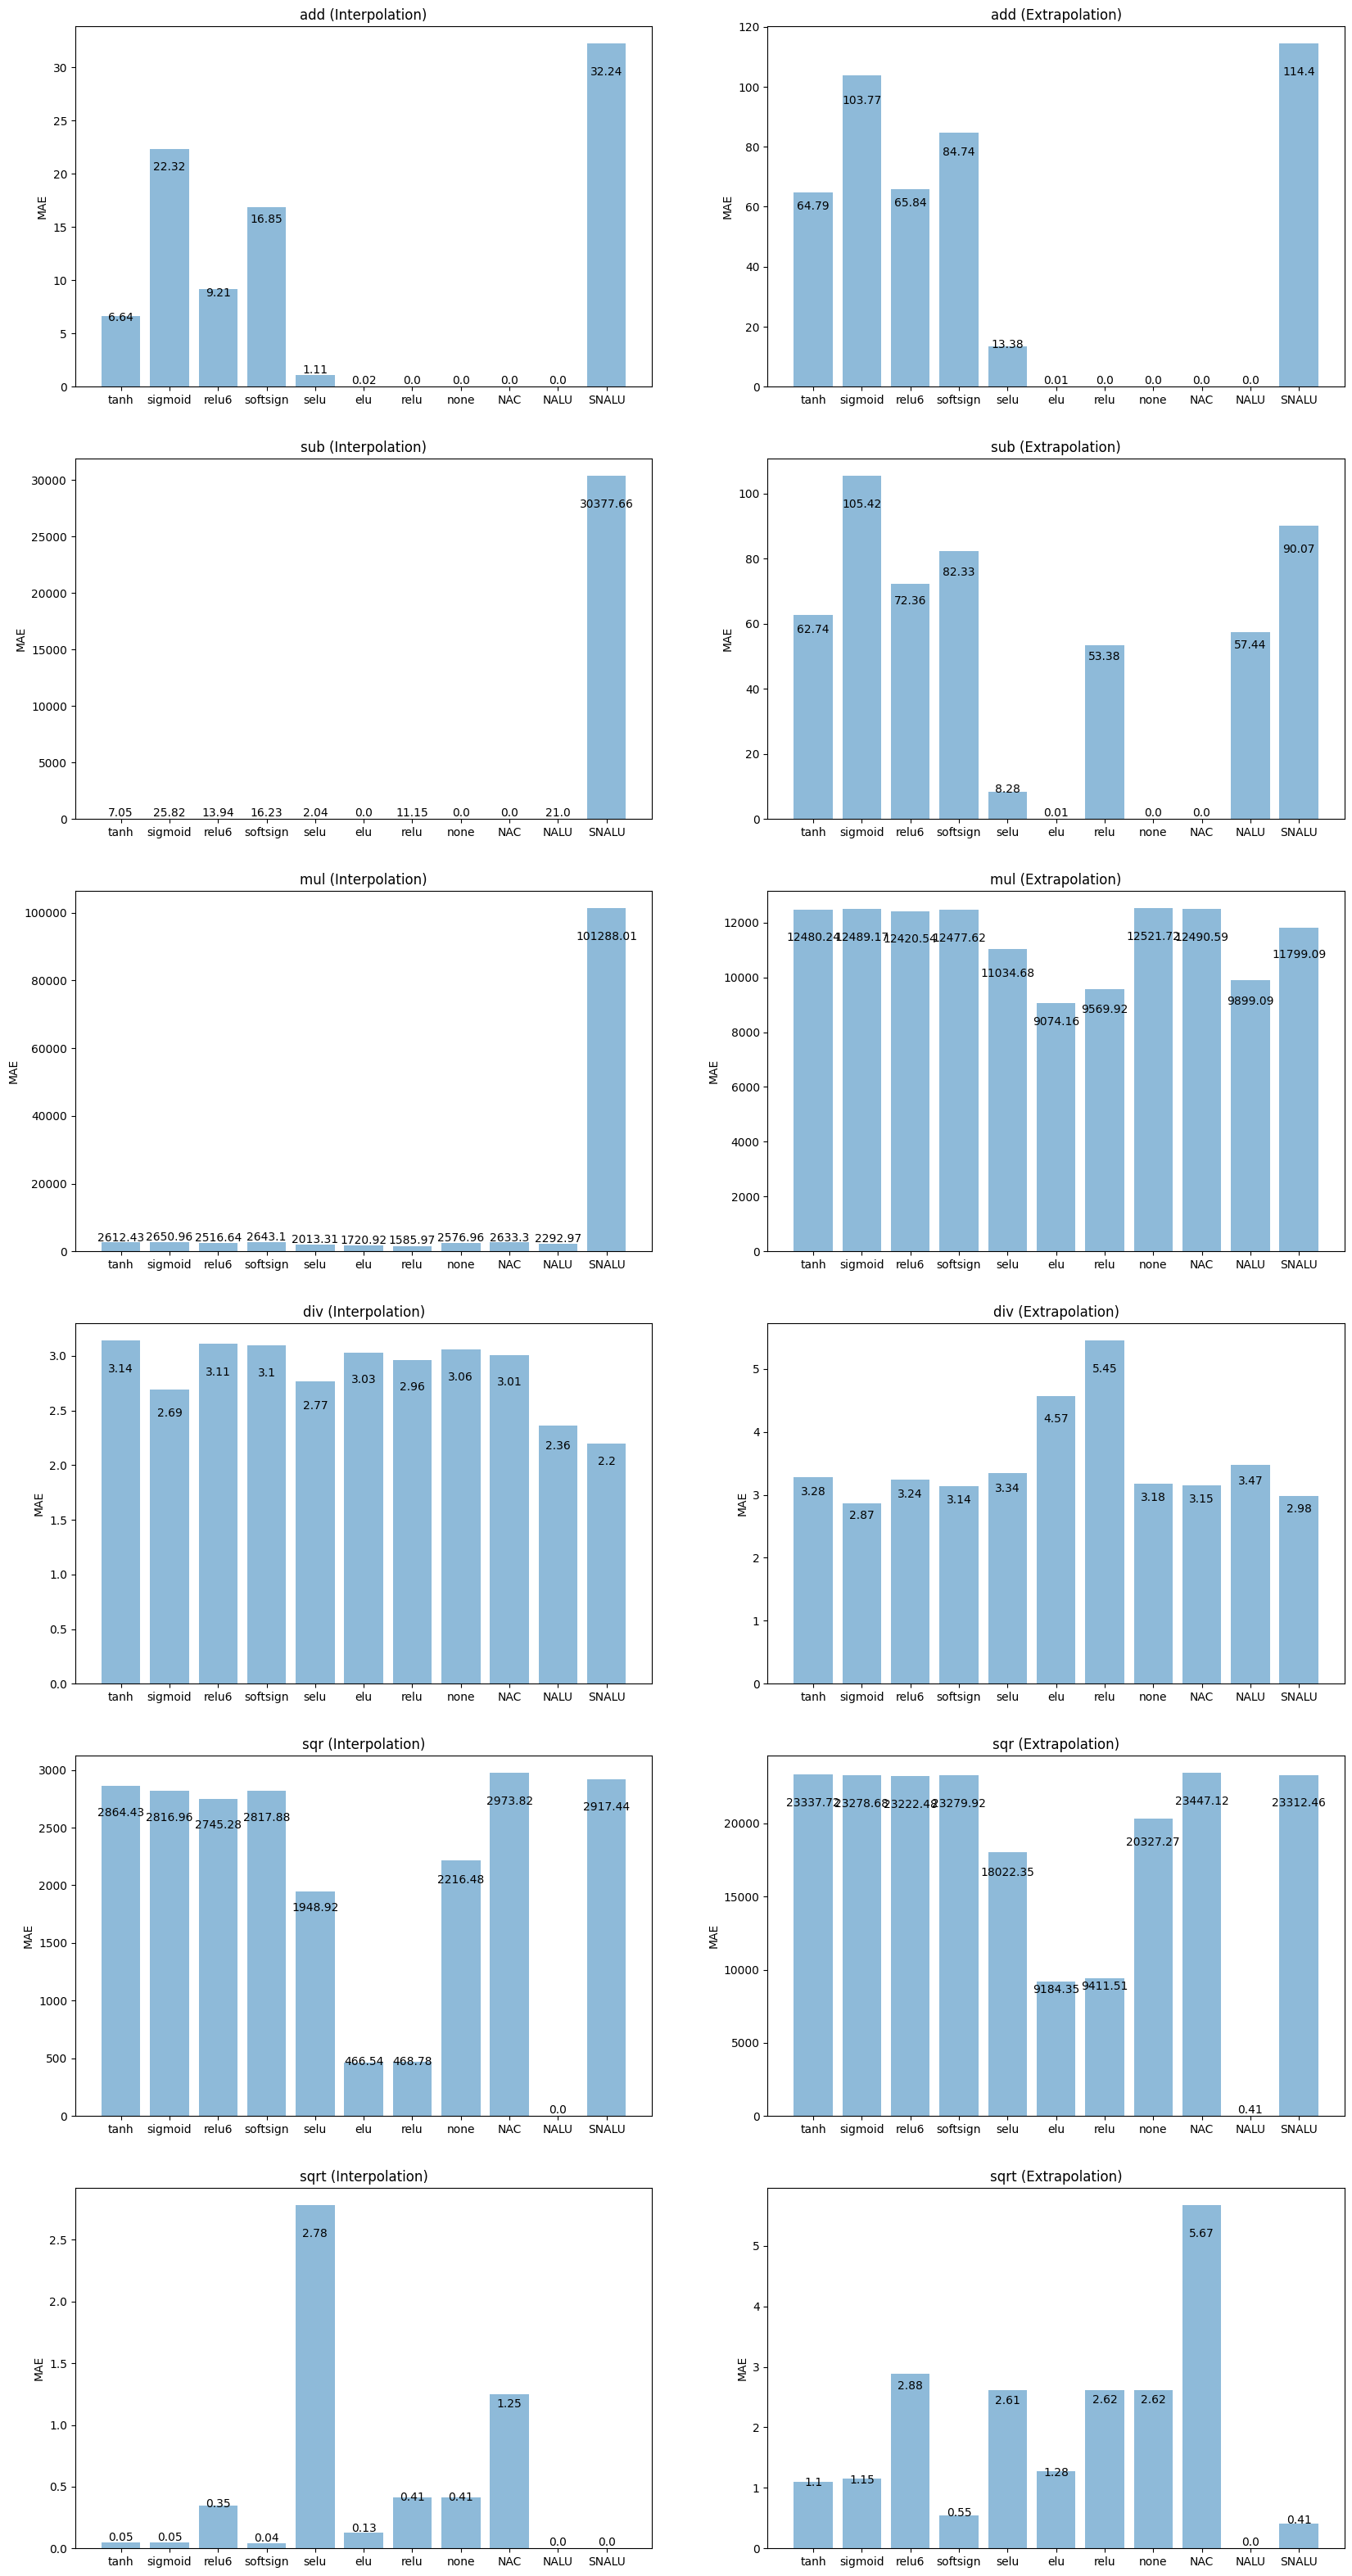

In [ ]:
def train(model, data, n_epochs, optimizer_class, lr, verbose=False):
    x, y = data
    loss_fn = nn.MSELoss()
    opt = optimizer_class(model.trainable_params(), learning_rate=lr)
    abs_fn = ops.Abs()
    mean_fn = ops.ReduceMean()


    class TrainStep(nn.Cell):
        def __init__(self, network, optimizer):
            super(TrainStep, self).__init__(auto_prefix=False)
            self.network = network
            self.network.set_train()
            self.optimizer = optimizer
            self.loss_fn = loss_fn
            self.abs_fn = abs_fn
            self.mean_fn = mean_fn
            self.grad = ops.value_and_grad(self.forward_fn, grad_position=None, weights=network.trainable_params())

        def forward_fn(self, x, y):
            logits = self.network(x)
            loss = self.loss_fn(logits.reshape(-1), y)
            return loss

        def construct(self, x, y):
            loss, grads = self.grad(x, y)
            self.optimizer(grads)
            return loss

    train_step = TrainStep(model, opt)

    early_break = 0
    early_break_max = 70000
    for epoch in range(n_epochs):
        loss = train_step(x, y)
        pred = model(x).reshape(-1)
        mae = mean_fn(abs_fn(pred - y))
        if loss.asnumpy() < 0.05 and mae.asnumpy() < 0.05:
            early_break += 1
            if early_break >= early_break_max:
                break
        else:
            early_break = 0
        if verbose and epoch % 50000 == 0:
            print(f'Epoch: {epoch}: mse={round(loss.asnumpy().item(), 2)}; mae={round(mae.asnumpy().item(), 2)}')
            
def test(model, data):
    x, y = data
    loss_fn = nn.MSELoss()
    abs_fn = ops.Abs()
    mean_fn = ops.ReduceMean()

    pred = model(x).reshape(-1)
    mse = loss_fn(pred, y)
    mae = mean_fn(abs_fn(pred - y))

    return round(mse.asnumpy().item(), 2), round(mae.asnumpy().item(), 2)

fun_dict = {
    'add': lambda x, y: x + y,
    'sub': lambda x, y: x - y,
    'mul': lambda x, y: x * y,
    'div': lambda x, y: x / y,
    'sqr': lambda x: np.power(x, 2),
    'sqrt': lambda x: np.sqrt(x)
}

models = {
    'tanh': nn.Tanh,
    'sigmoid': nn.Sigmoid,
    'relu6': nn.ReLU6,
    'softsign': nn.Softsign,
    'selu': nn.SeLU,
    'elu': nn.ELU,
    'relu': nn.ReLU,
    'none': None,
    'NAC': None,
    'NALU': None,
    'SNALU': None,
}
N_LAYERS = 2
OUT_DIM = 1
HIDDEN_DIM = 2
N_EPOCHS = int(6e5) 
OPTIMIZER = nn.Adam
LR = 0.0001
DATA_RANGE = (-200, 200)
LESS_THAN = -100
GREATER_THAN = 100
N_ELTS = 1000

interpolation_logs = {}
extrapolation_logs = {}

for fun_name, fun_op in fun_dict.items():
    if fun_name in ['sqr', 'sqrt']:
        single_dim = True
        in_dim = 1
    else:
        single_dim = False
        in_dim = 2

    data = create_data(*DATA_RANGE, N_ELTS, fun_op, fun_name, single_dim)
    data_train, data_test, data_extra = split_data(data, less=LESS_THAN, greater=GREATER_THAN)

    interpolation_logs[fun_name] = {}
    extrapolation_logs[fun_name] = {}

    for model_name, act in models.items():
        if model_name == 'NAC':
            model = snalu_ms.StackedNAC(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        elif model_name == 'NALU':
            model = snalu_ms.StackedNALU(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        elif model_name == 'SNALU':
            model = snalu_ms.StackedNALU(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM)
        else:
            model = mlp_ms.MLP(N_LAYERS, in_dim, OUT_DIM, HIDDEN_DIM, act)

        train(model, data_train, N_EPOCHS, OPTIMIZER, LR)
        _, mae_inter = test(model, data_test)
        _, mae_extra = test(model, data_extra)

        interpolation_logs[fun_name][model_name] = mae_inter
        extrapolation_logs[fun_name][model_name] = mae_extra

        print(f'{fun_name.ljust(10)}: {model_name.ljust(10)}: mae inter: {mae_inter}, mae extra: {mae_extra}')

        del model
    
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., 0.9 * height,
                str(height), ha='center', va='bottom')

idx = 1
n_rows = len(interpolation_logs.keys())
figure = plt.figure(figsize=(20, 40))

for fun_name in interpolation_logs.keys():
    ax1 = figure.add_subplot(n_rows, 2, idx)

    items = list(interpolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(interpolation_logs[fun_name].values())

    rect1 = ax1.bar(y_pos, mae, align='center', alpha=0.5)
    ax1.set_xticks(np.arange(len(items)))
    ax1.set_xticklabels(items)
    ax1.set_ylabel('MAE')
    ax1.set_title(f'{fun_name} (Interpolation)')
    autolabel(rect1, ax1)

    ax2 = figure.add_subplot(n_rows, 2, idx + 1)

    items = list(extrapolation_logs[fun_name].keys())
    y_pos = np.arange(len(items))
    mae = list(extrapolation_logs[fun_name].values())

    rect2 = ax2.bar(y_pos, mae, align='center', alpha=0.5)
    ax2.set_xticks(np.arange(len(items)))
    ax2.set_xticklabels(items)
    ax2.set_ylabel('MAE')
    ax2.set_title(f'{fun_name} (Extrapolation)')
    autolabel(rect2, ax2)

    idx += 2


plt.savefig('results2.png')